<a href="https://colab.research.google.com/github/michalgorul/classification-of-musical-genres/blob/main/GTZAN_MG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# !pip install tensorflow==2.10.0 pandas==1.5.0 numpy==1.23.3 seaborn==0.12.0 scikit-learn==1.1.2 librosa==0.9.2 imageio==2.22.3
!pip install pydub==0.25.1
!pip install mlxtend==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.4 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [3]:
import os
import random
import imageio
import librosa
import librosa.display
import shutil
import glob
import numpy as np

from typing import Tuple, Dict, List, Optional
from matplotlib import pyplot as plt
from PIL import ImageFile
from keras import models, layers, activations, optimizers, losses, metrics, Sequential, regularizers
from keras.layers import Flatten
from mlxtend.plotting import plot_confusion_matrix

# Global variables

In [4]:
genres = [
            "blues",
            "classical",
            "country",
            "disco",
            "hiphop",
            "jazz",
            "metal",
            "pop",
            "reggae",
            "rock",
        ]

gtzan_wavs = "/content/drive/MyDrive/GTZAN/wavs"
gtzan_spectograms = "/content/drive/MyDrive/GTZAN/spectograms"

gtzan_train_dir = "/content/drive/MyDrive/GTZAN/train"
gtzan_val_dir = "/content/drive/MyDrive/GTZAN/validation"
gtzan_test_dir = "/content/drive/MyDrive/GTZAN/test"

directories: Dict[str, str] = {
    "train_dir": gtzan_train_dir,
    "val_dir": gtzan_val_dir,
    "test_dir": gtzan_test_dir,
}

image_target_size = (288, 432)

# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Random spectogram

In [ ]:
def get_path_name_file(file_path: Optional[str], dir: str = "spectograms") -> Tuple[str, str]:
  selected_dir = gtzan_spectograms if dir == "spectograms" else gtzan_wavs
  if not file_path:
    directory_name = random.choice(os.listdir(selected_dir))
    file_name = random.choice(
        os.listdir(selected_dir + "/" + directory_name)
    )
    file_path = f"{selected_dir}/{directory_name}/{file_name}"
    return file_path, file_name
  return file_path, file_path.split("\\")[-1]

file_path, file_name = get_path_name_file(file_path=None)

print(f"Random spectogram file path: \n\t{file_path}\n")
print(f"Random spectogram file name: \n\t{file_name}\n")

Random spectogram file path: 
	/content/drive/MyDrive/GTZAN/spectograms/pop/pop00004.png

Random spectogram file name: 
	pop00004.png



Image dimensions: 
	(288, 432, 4)


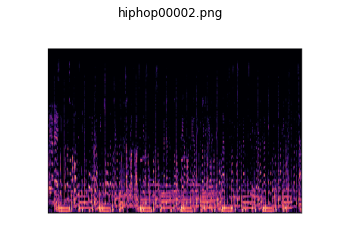

In [ ]:
def show_spectogram_from_dataset(file_path: Optional[str]) -> None:
  file_path, file_name = get_path_name_file(file_path=file_path)
  img = imageio.imread(file_path)
  print(f"Image dimensions: \n\t{img.shape}")

  plt.imshow(img)
  plt.title(file_name)
  plt.axis("off")
  plt.show()
  return

show_spectogram_from_dataset(file_path=None)

## Decibel spectogram from wav file

Shape of d object: (1025, 1293)


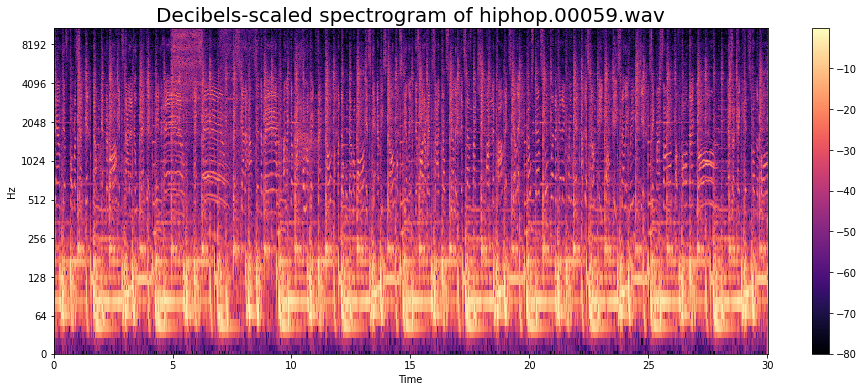

In [ ]:
def create_decibel_spectogram_from_wav_file(sound_file_path: Optional[str]) -> None:
  wav_file_path, wav_file_name = get_path_name_file(file_path=sound_file_path, dir="wavs")
  y, sample_rate = librosa.load(wav_file_path)

  # Short-time Fourier transform (STFT).
  d = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
  print("Shape of d object:", np.shape(d))
  
  # Convert amplitude spectrogram to Decibels-scaled spectrogram.
  decibels = librosa.amplitude_to_db(d, ref=np.max)
  
  # Creating the spectogram.
  plt.figure(figsize=(16, 6))
  librosa.display.specshow(
      decibels, sr=sample_rate, hop_length=512, x_axis="time", y_axis="log"
  )
  plt.colorbar()
  plt.title(f"Decibels-scaled spectrogram of {wav_file_name}", fontsize=20)
  plt.show()
  return

create_decibel_spectogram_from_wav_file(sound_file_path=None)

## Mel spectogram from wav file

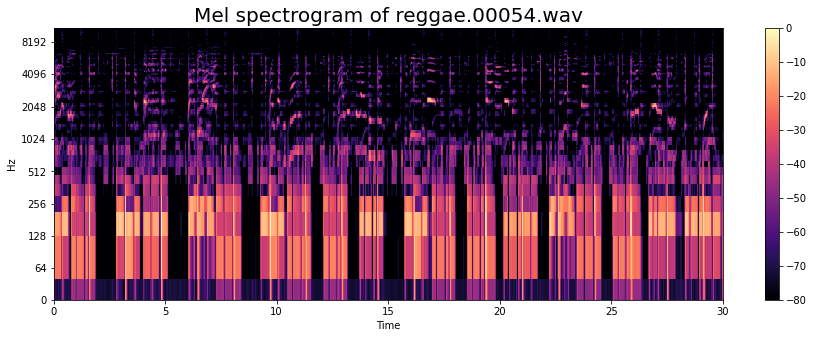

In [ ]:
def create_mel_spectogram_from_sound_file(sound_file_path: Optional[str]) -> None:
  wav_file_path, wav_file_name = get_path_name_file(file_path=sound_file_path, dir="wavs")
  y, sample_rate = librosa.load(wav_file_path)

  s = librosa.feature.melspectrogram(y=y, sr=sample_rate)
  decibels = librosa.amplitude_to_db(s, ref=np.max)
  plt.figure(figsize=(15, 5))
  librosa.display.specshow(
      decibels, sr=sample_rate, hop_length=512, x_axis="time", y_axis="log"
  )
  plt.colorbar()
  plt.title(f"Mel spectrogram of {wav_file_name}", fontsize=20)
  plt.show()
  return

create_mel_spectogram_from_sound_file(sound_file_path=None)

# Data initialization

### Utils

In [5]:
def copy_files(file_paths: List[str], dest_dir: str) -> None:
  try:
    for file in file_paths:
        shutil.copy(
            file,
            os.path.join(
                os.path.join(dest_dir),
                os.path.split(file)[1],
            ),
        )
  except KeyError as e:
      print(f"Failed to copy files to destination directory, error={e}")


def create_directories(directories: Dict[str, str]) -> None:
  # Create folders
  for folder_name, path in directories.items():
    if os.path.exists(path):
      shutil.rmtree(path)
      os.mkdir(path)
    else:
      os.mkdir(path)

def create_directory(path: str) -> None:
  # Create folder
  if os.path.exists(path):
    shutil.rmtree(path)
    os.mkdir(path)
  else:
    os.mkdir(path)
  
def remove_directories(directories: Dict[str, str]) -> None:
  # Remove folders
  for folder_name, path in directories.items():
    if os.path.exists(path):
      shutil.rmtree(path)

### Init data with existing spectograms

In [ ]:
def data_init_10sec_from_dataset() -> None:

  create_directories(directories)

  images_path = gtzan_spectograms
  genres = list(os.listdir(images_path))

  print("Genres:", genres)

  for genre in genres:
    print(f"\nCurrent genre: {genre}")

    # Finding all images & split in train, test, and validation
    src_file_paths = []

    for im in glob.glob(os.path.join(images_path, f"{genre}", "*.png"), recursive=True):
        src_file_paths.append(im)

    # Randomizing directories content
    random.shuffle(src_file_paths)

    files_len = len(src_file_paths)

    test_files = src_file_paths[0:int(files_len * 0.05)]
    val_files = src_file_paths[int(files_len * 0.05):int(files_len * 0.15)]
    train_files = src_file_paths[int(files_len * 0.15):]

    print("Number of test files:",len(test_files))
    print("Number of validation files:",len(val_files))
    print("Number of train files:",len(train_files))

    #  make destination folders for train and test images
    for folder_name, path in directories.items():
        if not os.path.exists(path + f"/{genre}"):
            os.mkdir(f"{path}/{genre}")

    # Coping training and testing images over
    copy_files(
        file_paths=train_files, dest_dir=f"{directories['train_dir']}/{genre}/"
    )
    copy_files(
        file_paths=test_files, dest_dir=f"{directories['test_dir']}/{genre}/"
    )
    copy_files(file_paths=val_files, dest_dir=f"{directories['val_dir']}/{genre}/")

data_init_10sec_from_dataset()

Genres: ['disco', 'rock', 'hiphop', 'pop', 'blues', 'metal', 'jazz', 'classical', 'reggae', 'country']

Current genre: disco
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: rock
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: hiphop
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: pop
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: blues
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: metal
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: jazz
Number of test files: 4
Number of validation files: 10
Number of train files: 85

Current genre: classical
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: reggae
Number of test files: 5
Number of validation file

### Divide the songs into test, train and val dirs

In [33]:
gtzan_train_temp_dir = "/content/drive/MyDrive/GTZAN/train_temp"
gtzan_val_temp_dir = "/content/drive/MyDrive/GTZAN/validation_temp"
gtzan_test_temp_dir = "/content/drive/MyDrive/GTZAN/test_temp"

gtzan_train_temp_dir_3sec = "/content/drive/MyDrive/GTZAN/train_temp_3sec"
gtzan_val_temp_dir_3sec = "/content/drive/MyDrive/GTZAN/validation_temp_3sec"
gtzan_test_temp_dir_3sec = "/content/drive/MyDrive/GTZAN/test_temp_3sec"

wavs_directories_temp: Dict[str, str] = {
    "train_dir": gtzan_train_temp_dir,
    "val_dir": gtzan_val_temp_dir,
    "test_dir": gtzan_test_temp_dir,
}

wavs_directories_temp_3sec: Dict[str, str] = {
    "train_dir": gtzan_train_temp_dir_3sec,
    "val_dir": gtzan_val_temp_dir_3sec,
    "test_dir": gtzan_test_temp_dir_3sec,
}

In [34]:
def devide_songs() -> None:
  create_directories(wavs_directories_temp)

  songs_path = gtzan_wavs
  genres = list(os.listdir(songs_path))
  
  print("Genres:", genres)

  for genre in genres:
    print(f"\nCurrent genre: {genre}")

    # Finding all wavs & split in train, test, and validation
    src_file_paths = []

    for im in glob.glob(os.path.join(songs_path, f"{genre}", "*.wav"), recursive=True):
        src_file_paths.append(im)

    # Randomizing directories content
    random.shuffle(src_file_paths)

    files_len = len(src_file_paths)

    test_files = src_file_paths[0:int(files_len * 0.05)]
    val_files = src_file_paths[int(files_len * 0.05):int(files_len * 0.15)]
    train_files = src_file_paths[int(files_len * 0.15):]

    print("Number of test files:",len(test_files))
    print("Number of validation files:",len(val_files))
    print("Number of train files:",len(train_files))

    #  make destination folders for train and test images
    for folder_name, path in wavs_directories_temp.items():
        if not os.path.exists(path + f"/{genre}"):
            os.mkdir(f"{path}/{genre}")

    # Coping training and testing images over
    copy_files(
        file_paths=train_files, dest_dir=f"{wavs_directories_temp['train_dir']}/{genre}/"
    )
    copy_files(
        file_paths=test_files, dest_dir=f"{wavs_directories_temp['test_dir']}/{genre}/"
    )
    copy_files(file_paths=val_files, dest_dir=f"{wavs_directories_temp['val_dir']}/{genre}/")


devide_songs()

Genres: ['rock', 'pop', 'reggae', 'hiphop', 'country', 'blues', 'classical', 'metal', 'disco', 'jazz']

Current genre: rock
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: pop
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: reggae
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: hiphop
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: country
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: blues
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: classical
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: metal
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: disco
Number of test files: 5
Number of validation f

### Mel-scaled - 3 sec songs

In [ ]:
from pydub import AudioSegment

def make_3_sec_wavs(wavs_path: str, dest_path: str) -> None:
  # create_directories(wavs_directories_temp_3sec)
  create_directory(dest_path)
  genres = list(os.listdir(wavs_path))
  i = 0
  for genre in genres:
    print(f"\tCurrent genre: {genre}")
    # Finding all wavs & create 3sec songs
    src_file_paths = []

    for im in glob.glob(os.path.join(wavs_path, f"{genre}", "*.wav"), recursive=True):
      src_file_paths.append(im)
    j = 0
    for song in src_file_paths:
      j = j + 1
      for w in range(0, 10):
        try:
          i = i + 1
          t1 = 3 * w * 1000
          t2 = 3 * (w + 1) * 1000
          new_audio = AudioSegment.from_wav(song)
          new = new_audio[t1:t2]

          genre_dir_path = f"{dest_path}/{genre}/"
          
          if not os.path.exists(genre_dir_path):
              os.mkdir(genre_dir_path)

          file_name = genre + str(j) + str(w)

          new.export(
              f"{genre_dir_path}/{file_name}.wav",
              format="wav",
          )
        except Exception as e:
          print(e)

In [ ]:
print("Creating train files:")
make_3_sec_wavs(gtzan_train_temp_dir, gtzan_train_temp_dir_3sec)

Creating train files:
	Current genre: rock
	Current genre: pop
	Current genre: reggae
	Current genre: hiphop
	Current genre: country
	Current genre: blues
	Current genre: classical
	Current genre: metal
	Current genre: disco
	Current genre: jazz


In [ ]:
print("\nCreating validation files:")
make_3_sec_wavs(gtzan_val_temp_dir, gtzan_val_temp_dir_3sec)


Creating validation files:
	Current genre: rock
	Current genre: pop
	Current genre: reggae
	Current genre: hiphop
	Current genre: country
	Current genre: blues
	Current genre: classical
	Current genre: metal
	Current genre: disco
	Current genre: jazz


In [ ]:
print("\nCreating test files:")
make_3_sec_wavs(gtzan_test_temp_dir, gtzan_test_temp_dir_3sec)


Creating test files:
	Current genre: rock
	Current genre: pop
	Current genre: reggae
	Current genre: hiphop
	Current genre: country
	Current genre: blues
	Current genre: classical
	Current genre: metal
	Current genre: disco
	Current genre: jazz


In [ ]:
from matplotlib.pyplot import figure

def make_3_sec_images(genre: str, songs_path: str, images_path: str, last_song: int = 0) -> None:
  g = genre
  j = 0
  for filename in os.listdir(os.path.join(songs_path, f"{g}")):
    j = j + 1
    if j > last_song:
      if not j % 10:
        print(f"Current file in {g}: {j}")

      song = os.path.join(f"{songs_path}/{g}", f"{filename}")

      y, sr = librosa.load(song)
      mels = librosa.feature.melspectrogram(y=y, sr=sr)
      figure(figsize=(4, 2))
      plt.imshow(librosa.power_to_db(mels, ref=np.max), aspect="auto")
      plt.axis("off")

      genre_dir_path = f"{images_path}/{g}"
      if not os.path.exists(genre_dir_path):
          os.mkdir(genre_dir_path)

      plt.savefig(f"{genre_dir_path}/{g + str(j)}.png")
      plt.close()


create_directories(directories)
for genre in genres:
  # make_3_sec_images(genre, gtzan_train_temp_dir_3sec, gtzan_train_dir)
  # make_3_sec_images(genre, gtzan_val_temp_dir_3sec, gtzan_val_dir)
  make_3_sec_images(genre, gtzan_test_temp_dir_3sec, gtzan_test_dir)

Current file in blues: 10
Current file in blues: 20
Current file in blues: 30
Current file in blues: 40
Current file in blues: 50
Current file in classical: 10
Current file in classical: 20
Current file in classical: 30
Current file in classical: 40
Current file in classical: 50
Current file in country: 10
Current file in country: 20
Current file in country: 30
Current file in country: 40
Current file in country: 50
Current file in disco: 10
Current file in disco: 20
Current file in disco: 30
Current file in disco: 40
Current file in disco: 50
Current file in hiphop: 10
Current file in hiphop: 20
Current file in hiphop: 30
Current file in hiphop: 40
Current file in hiphop: 50
Current file in jazz: 10
Current file in jazz: 20
Current file in jazz: 30
Current file in jazz: 40
Current file in metal: 10
Current file in metal: 20
Current file in metal: 30
Current file in metal: 40
Current file in metal: 50
Current file in pop: 10
Current file in pop: 20
Current file in pop: 30
Current file 

In [ ]:
remove_directories(wavs_directories_temp)
remove_directories(wavs_directories_temp_3sec)

### Mel-scaled - 30 sec songs

In [35]:
from matplotlib.pyplot import figure

def make_mel_images(genre: str, songs_path: str, images_path: str, last_song: int = 0) -> None:
  g = genre
  j = 0
  for filename in os.listdir(os.path.join(songs_path, f"{g}")):
    j = j + 1
    if j > last_song:
      print(f"Current file in {g}: {j}")

      song = os.path.join(f"{songs_path}/{g}", f"{filename}")

      y, sr = librosa.load(song)
      mels = librosa.feature.melspectrogram(y=y, sr=sr)
      figure(figsize=(6, 3))
      plt.imshow(librosa.power_to_db(mels, ref=np.max), aspect="auto")
      plt.axis("off")

      genre_dir_path = f"{images_path}/{g}"
      if not os.path.exists(genre_dir_path):
          os.mkdir(genre_dir_path)

      plt.savefig(f"{genre_dir_path}/{g + str(j)}.png")
      plt.close()


create_directories(directories)
for genre in genres:
  make_mel_images(genre, gtzan_train_temp_dir, gtzan_train_dir)
  make_mel_images(genre, gtzan_val_temp_dir, gtzan_val_dir)
  make_mel_images(genre, gtzan_test_temp_dir, gtzan_test_dir)

Current file in blues: 1
Current file in blues: 2
Current file in blues: 3
Current file in blues: 4
Current file in blues: 5
Current file in blues: 6
Current file in blues: 7
Current file in blues: 8
Current file in blues: 9
Current file in blues: 10
Current file in blues: 11
Current file in blues: 12
Current file in blues: 13
Current file in blues: 14
Current file in blues: 15
Current file in blues: 16
Current file in blues: 17
Current file in blues: 18
Current file in blues: 19
Current file in blues: 20
Current file in blues: 21
Current file in blues: 22
Current file in blues: 23
Current file in blues: 24
Current file in blues: 25
Current file in blues: 26
Current file in blues: 27
Current file in blues: 28
Current file in blues: 29
Current file in blues: 30
Current file in blues: 31
Current file in blues: 32
Current file in blues: 33
Current file in blues: 34
Current file in blues: 35
Current file in blues: 36
Current file in blues: 37
Current file in blues: 38
Current file in blues

In [ ]:
remove_directories(wavs_directories_temp)

### Constant-Q transform - 30 sec songs 

In [ ]:
from matplotlib.pyplot import figure

def make_cqt_images(genre: str, songs_path: str, images_path: str, last_song: int = 0) -> None:
  g = genre
  j = 0
  for filename in os.listdir(os.path.join(songs_path, f"{g}")):
    j = j + 1
    if j > last_song:
      print(f"Current file in {g}: {j}")

      song = os.path.join(f"{songs_path}/{g}", f"{filename}")

      y, sr = librosa.load(song)
      C = np.abs(librosa.cqt(y, sr=sr))
      figure(figsize=(6, 3))
      plt.imshow(librosa.amplitude_to_db(C, ref=np.max), aspect="auto")
      plt.axis("off")

      genre_dir_path = f"{images_path}/{g}"
      if not os.path.exists(genre_dir_path):
          os.mkdir(genre_dir_path)

      plt.savefig(f"{genre_dir_path}/{g + str(j)}.png")
      plt.close()


create_directories(directories)
for genre in genres:
  make_cqt_images(genre, gtzan_train_temp_dir, gtzan_train_dir)
  make_cqt_images(genre, gtzan_val_temp_dir, gtzan_val_dir)
  make_cqt_images(genre, gtzan_test_temp_dir, gtzan_test_dir)

Current file in blues: 1
Current file in blues: 2
Current file in blues: 3
Current file in blues: 4
Current file in blues: 5
Current file in blues: 6
Current file in blues: 7
Current file in blues: 8
Current file in blues: 9
Current file in blues: 10
Current file in blues: 11
Current file in blues: 12
Current file in blues: 13
Current file in blues: 14
Current file in blues: 15
Current file in blues: 16
Current file in blues: 17
Current file in blues: 18
Current file in blues: 19
Current file in blues: 20
Current file in blues: 21
Current file in blues: 22
Current file in blues: 23
Current file in blues: 24
Current file in blues: 25
Current file in blues: 26
Current file in blues: 27
Current file in blues: 28
Current file in blues: 29
Current file in blues: 30
Current file in blues: 31
Current file in blues: 32
Current file in blues: 33
Current file in blues: 34
Current file in blues: 35
Current file in blues: 36
Current file in blues: 37
Current file in blues: 38
Current file in blues

In [ ]:
remove_directories(wavs_directories_temp)

### Variable-Q transform - 30 sec songs

In [ ]:
from matplotlib.pyplot import figure

def make_vqt_images(genre: str, songs_path: str, images_path: str, last_song: int = 0) -> None:
  g = genre
  j = 0
  for filename in os.listdir(os.path.join(songs_path, f"{g}")):
    j = j + 1
    if j > last_song:
      print(f"Current file in {g}: {j}")

      song = os.path.join(f"{songs_path}/{g}", f"{filename}")

      y, sr = librosa.load(song)
      V = np.abs(librosa.vqt(y, sr=sr))
      figure(figsize=(6, 3))
      plt.imshow(librosa.amplitude_to_db(V, ref=np.max), aspect="auto")
      plt.axis("off")

      genre_dir_path = f"{images_path}/{g}"
      if not os.path.exists(genre_dir_path):
          os.mkdir(genre_dir_path)

      plt.savefig(f"{genre_dir_path}/{g + str(j)}.png")
      plt.close()


create_directories(directories)
for genre in genres:
  make_vqt_images(genre, gtzan_train_temp_dir, gtzan_train_dir)
  make_vqt_images(genre, gtzan_val_temp_dir, gtzan_val_dir)
  make_vqt_images(genre, gtzan_test_temp_dir, gtzan_test_dir)

Current file in blues: 1
Current file in blues: 2
Current file in blues: 3
Current file in blues: 4
Current file in blues: 5
Current file in blues: 6
Current file in blues: 7
Current file in blues: 8
Current file in blues: 9
Current file in blues: 10
Current file in blues: 11
Current file in blues: 12
Current file in blues: 13
Current file in blues: 14
Current file in blues: 15
Current file in blues: 16
Current file in blues: 17
Current file in blues: 18
Current file in blues: 19
Current file in blues: 20
Current file in blues: 21
Current file in blues: 22
Current file in blues: 23
Current file in blues: 24
Current file in blues: 25
Current file in blues: 26
Current file in blues: 27
Current file in blues: 28
Current file in blues: 29
Current file in blues: 30
Current file in blues: 31
Current file in blues: 32
Current file in blues: 33
Current file in blues: 34
Current file in blues: 35
Current file in blues: 36
Current file in blues: 37
Current file in blues: 38
Current file in blues

In [ ]:
remove_directories(wavs_directories_temp)

### Semitone spectrogram (IIRT) - 30 sec songs

In [ ]:
from matplotlib.pyplot import figure

def make_iirt_images(genre: str, songs_path: str, images_path: str, last_song: int = 0) -> None:
  g = genre
  j = 0
  for filename in os.listdir(os.path.join(songs_path, f"{g}")):
    j = j + 1
    if j > last_song:
      print(f"Current file in {g}: {j}")

      song = os.path.join(f"{songs_path}/{g}", f"{filename}")

      y, sr = librosa.load(song)
      D = np.abs(librosa.iirt(y))
      figure(figsize=(6, 3))
      plt.imshow(librosa.amplitude_to_db(D, ref=np.max), aspect="auto")
      plt.axis("off")

      genre_dir_path = f"{images_path}/{g}"
      if not os.path.exists(genre_dir_path):
          os.mkdir(genre_dir_path)

      plt.savefig(f"{genre_dir_path}/{g + str(j)}.png")
      plt.close()


create_directories(directories)
for genre in genres:
  make_iirt_images(genre, gtzan_train_temp_dir, gtzan_train_dir)
  make_iirt_images(genre, gtzan_val_temp_dir, gtzan_val_dir)
  make_iirt_images(genre, gtzan_test_temp_dir, gtzan_test_dir)

In [ ]:
remove_directories(wavs_directories_temp)

### Short-time Fourier transform (STFT) - 30 sec songs


In [ ]:
from matplotlib.pyplot import figure

def make_stft_images(genre: str, songs_path: str, images_path: str, last_song: int = 0) -> None:
  g = genre
  j = 0
  for filename in os.listdir(os.path.join(songs_path, f"{g}")):
    j = j + 1
    if j > last_song:
      print(f"Current file in {g}: {j}")

      song = os.path.join(f"{songs_path}/{g}", f"{filename}")

      y, sr = librosa.load(song)
      S = np.abs(librosa.stft(y))
      figure(figsize=(6, 3))
      plt.imshow(librosa.amplitude_to_db(S, ref=np.max), aspect="auto")
      plt.axis("off")

      genre_dir_path = f"{images_path}/{g}"
      if not os.path.exists(genre_dir_path):
          os.mkdir(genre_dir_path)

      plt.savefig(f"{genre_dir_path}/{g + str(j)}.png")
      plt.close()


create_directories(directories)
for genre in genres:
  make_stft_images(genre, gtzan_train_temp_dir, gtzan_train_dir)
  make_stft_images(genre, gtzan_val_temp_dir, gtzan_val_dir)
  make_stft_images(genre, gtzan_test_temp_dir, gtzan_test_dir)

In [ ]:
remove_directories(wavs_directories_temp)

### Chroma Features - 30 sec songs

In [22]:
from matplotlib.pyplot import figure

def make_chroma_images(genre: str, songs_path: str, images_path: str, last_song: int = 0) -> None:
  g = genre
  j = 0
  for filename in os.listdir(os.path.join(songs_path, f"{g}")):
    j = j + 1
    if j > last_song:
      print(f"Current file in {g}: {j}")

      song = os.path.join(f"{songs_path}/{g}", f"{filename}")

      y, sr = librosa.load(song)
      S = np.abs(librosa.stft(y))
      chroma = np.abs(librosa.feature.chroma_stft(S=S, sr=sr))
      figure(figsize=(6, 3))
      plt.imshow(librosa.amplitude_to_db(chroma, ref=np.max), aspect="auto")
      plt.axis("off")

      genre_dir_path = f"{images_path}/{g}"
      if not os.path.exists(genre_dir_path):
          os.mkdir(genre_dir_path)

      plt.savefig(f"{genre_dir_path}/{g + str(j)}.png")
      plt.close()


create_directories(directories)
for genre in genres:
  make_chroma_images(genre, gtzan_train_temp_dir, gtzan_train_dir)
  make_chroma_images(genre, gtzan_val_temp_dir, gtzan_val_dir)
  make_chroma_images(genre, gtzan_test_temp_dir, gtzan_test_dir)

Current file in blues: 1
Current file in blues: 2
Current file in blues: 3
Current file in blues: 4
Current file in blues: 5
Current file in blues: 6
Current file in blues: 7
Current file in blues: 8
Current file in blues: 9
Current file in blues: 10
Current file in blues: 11
Current file in blues: 12
Current file in blues: 13
Current file in blues: 14
Current file in blues: 15
Current file in blues: 16
Current file in blues: 17
Current file in blues: 18
Current file in blues: 19
Current file in blues: 20
Current file in blues: 21
Current file in blues: 22
Current file in blues: 23
Current file in blues: 24
Current file in blues: 25
Current file in blues: 26
Current file in blues: 27
Current file in blues: 28
Current file in blues: 29
Current file in blues: 30
Current file in blues: 31
Current file in blues: 32
Current file in blues: 33
Current file in blues: 34
Current file in blues: 35
Current file in blues: 36
Current file in blues: 37
Current file in blues: 38
Current file in blues

In [20]:
remove_directories(wavs_directories_temp)

### Sanity data test

In [ ]:
def sanity_data_test() -> None:
  print(
    "Genres directories in train data:",
    len(os.listdir(directories["train_dir"])),
  )
  print(
    "Genres directories in test data:", len(os.listdir(directories["test_dir"]))
  )
  print(
    "Genres directories in validation data:",
    len(os.listdir(directories["val_dir"])),
  )

  print("\nTotal number of images in:")
  for genre in genres:
    print()
    for folder_name, path in directories.items():
      print(
        f"\t{folder_name} of {genre} songs: "
        + str(len(os.listdir(f"{directories[folder_name]}/{genre}"))),
      )

sanity_data_test()

Genres directories in train data: 10
Genres directories in test data: 1
Genres directories in validation data: 10

Total number of images in:

	train_dir of blues songs: 85
	val_dir of blues songs: 10


FileNotFoundError: ignored

# Networks

## Necessary for all

### Copy files to Colab instance

In [36]:
train_dir_on_colab_instance = "/content/bin/data/train"
val_dir_on_colab_instance = "/content/bin/data/val"

if os.path.exists(train_dir_on_colab_instance):
  shutil.rmtree(train_dir_on_colab_instance)

if os.path.exists(val_dir_on_colab_instance):
  shutil.rmtree(val_dir_on_colab_instance)

shutil.copytree(gtzan_train_dir, train_dir_on_colab_instance)
shutil.copytree(gtzan_val_dir, val_dir_on_colab_instance)

'/content/bin/data/val'

### Plotting functions

In [37]:
def show_training_and_validation_loss(
    epochs: range, loss_values: List[float], val_loss_values: List[float]
) -> None:
  plt.plot(epochs, loss_values, "bo", label="Training loss")
  plt.plot(epochs, val_loss_values, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()


def show_training_and_validation_accuracy(
    epochs: range, acc: List[float], val_acc: List[float]
) -> None:
  plt.plot(epochs, acc, "bo", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

### Common fit and evaluate function

In [38]:
def fit_model(model, x, y, train_steps, epochs, validation_data, validation_steps, model_path):
  history = model.fit(
        x=x,
        y=y,
        steps_per_epoch=train_steps,
        epochs=EPOCHS,
        validation_data=val_data,
        validation_steps=val_steps,
    )

  try:
    model.save(model_path)
    print(f"Model saved at {model_path}")
  except Exception as e:
    print(f"Failed to save model, error={e}")


  train_loss_values = history.history.get("loss")
  val_loss_values = history.history.get("val_loss")
  train_accuracy = history.history.get("categorical_accuracy")
  val_accuracy = history.history.get("val_categorical_accuracy")
  num_of_epochs = range(1, len(train_accuracy) + 1)

  show_training_and_validation_loss(
      epochs=num_of_epochs, loss_values=train_loss_values, val_loss_values=val_loss_values
  )

  show_training_and_validation_accuracy(
      epochs=num_of_epochs, acc=train_accuracy, val_acc=val_accuracy
  )

def evaluate_model(model, train_x, train_y, val_x, val_y):
  train_score = model.evaluate(
      x=train_x, 
      y=train_y, 
      verbose=0
  )

  print('Train loss:', round(train_score[0], 4))
  print('Train accuracy:', round(train_score[1], 4))

  val_score = model.evaluate(
      x=val_x, 
      y=val_y, 
      verbose=0
  )

  print('Validation loss:', round(val_score[0], 4))
  print('Validation accuracy:', round(val_score[1], 4))

### Test directory initialization

In [39]:
# make test folder with one class

def init_test_dir(test_directory: str) -> None:
  test_dir = test_directory + "/images/"
  try:
    if not os.path.exists(test_dir):
      create_directory(test_dir)
      print("Created 'images' folder")
    else:
      print("'images' folder already exists")
      return

    for genre in genres:
      source = gtzan_test_dir + "/" + genre + "/"

      # code to move the files from sub-folder to main folder.
      files = os.listdir(source)
      for file in files:
          file_name = os.path.join(source, file)
          shutil.move(file_name, test_dir)
      
      os.rmdir(source)
      print(f"\tFiles from {genre} moved")

    print("Initialized Test directory successfuly")
  except Exception as e:
    print(f"Failed initializing test directory, error={e}")
    raise

init_test_dir(gtzan_test_dir)

Created 'images' folder
	Files from blues moved
	Files from classical moved
	Files from country moved
	Files from disco moved
	Files from hiphop moved
	Files from jazz moved
	Files from metal moved
	Files from pop moved
	Files from reggae moved
	Files from rock moved
Initialized Test directory successfuly


## My network

### Data generators

In [40]:
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

# MY_NETWORK_BATCH_SIZE = 128
MY_NETWORK_BATCH_SIZE = 20


def get_train_data_generator() -> DirectoryIterator:
  print("Creating train data generator")
  train_datagen = ImageDataGenerator(rescale=1.0 / 255)

  train_dir = train_dir_on_colab_instance
  target_size = image_target_size

  train_generator = train_datagen.flow_from_directory(
      train_dir, 
      target_size=target_size, 
      batch_size=MY_NETWORK_BATCH_SIZE, 
      class_mode="categorical", 
      color_mode="rgba"
  )
  return train_generator


def get_validation_data_generator() -> DirectoryIterator:
  print("Creating validation data generator")
  validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

  validation_dir = val_dir_on_colab_instance
  target_size = image_target_size

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir, 
      target_size=target_size, 
      batch_size=MY_NETWORK_BATCH_SIZE, 
      class_mode="categorical",  
      color_mode="rgba"
  )
  return validation_generator


def list_output_of_generators() -> None:
  for data_batch, labels_batch in get_train_data_generator():
    print("Train generator:")
    print("\tData batch shape:", data_batch.shape)
    print("\tLabels batch shape:", labels_batch.shape)
    print()
    break

  for data_batch, labels_batch in get_validation_data_generator():
    print("Validation generator:")
    print("\tData batch shape:", data_batch.shape)
    print("\tLabels batch shape:", labels_batch.shape)
    break

### Model

In [41]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


def build_my_model() -> Sequential:
  """
  Function creating keras model
  :return: a model
  """

  input_shape = (*image_target_size, 4)
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(layers.MaxPooling2D((2, 2)))
  
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  
  model.add(layers.Flatten())
  
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(10, activation='sigmoid'))

  model.summary()

  model.compile(
      optimizer=optimizers.RMSprop(learning_rate=1e-4),
      loss=losses.categorical_crossentropy,
      metrics=[metrics.categorical_accuracy],
  )

  return model

### Fit

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 286, 430, 32)      1184      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 143, 215, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 141, 213, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 70, 106, 64)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 68, 104, 128)      73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 34, 52, 128)     

Model saved at /content/drive/MyDrive/GTZAN/models/my_network


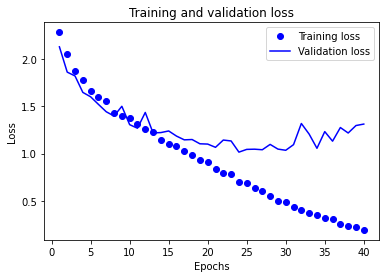

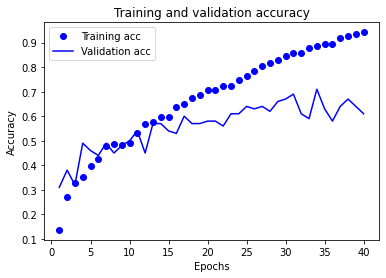

In [42]:
# def fit_model(model, x, y, train_steps, epochs, validation_data, validation_steps, model_path):
my_model = build_my_model() 

train_data = get_train_data_generator()
val_data = get_validation_data_generator()

train_steps = train_data.samples / train_data.batch_size
val_steps = val_data.samples / val_data.batch_size

my_model_path = "/content/drive/MyDrive/GTZAN/models/my_network"

EPOCHS = 40

fit_model(
    model=my_model, 
    x=train_data, 
    y=None,
    train_steps=train_steps,
    epochs=EPOCHS,
    validation_data=val_data,
    validation_steps=val_steps,
    model_path=my_model_path
)

### Evaluate

In [43]:
# def evaluate_model(train_x, train_y, val_x, val_y):

evaluate_model(
    model=my_model,
    train_x=train_data, 
    train_y=None, 
    val_x=val_data, 
    val_y=None
)

Train loss: 0.0874
Train accuracy: 0.9812
Validation loss: 1.311
Validation accuracy: 0.61


### Predict

In [44]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

test_dir = gtzan_test_dir
test_datagen = ImageDataGenerator(rescale=1./255)

# shuffle=False in order to preserve the order of filenames and predictions.
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=image_target_size,
    color_mode="rgba",
    class_mode=None,
    shuffle=False,
    seed=42
)

predictions = my_model.predict(
    test_generator,
)

predicted_class_indices=np.argmax(predictions,axis=1)
labels = genres
# labels = train_data.class_indices
# labels = dict((v,k) for k,v in labels.items())
prediction_results = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                      "Predictions": prediction_results})
print(results)

Found 49 images belonging to 1 classes.
2/2 [==============================] - 1s 142ms/step
                 Filename Predictions
0       images/blues1.png       blues
1       images/blues2.png       blues
2       images/blues3.png       blues
3       images/blues4.png       blues
4       images/blues5.png       blues
5   images/classical1.png   classical
6   images/classical2.png   classical
7   images/classical3.png   classical
8   images/classical4.png   classical
9   images/classical5.png   classical
10    images/country1.png       disco
11    images/country2.png     country
12    images/country3.png       blues
13    images/country4.png     country
14    images/country5.png     country
15      images/disco1.png       disco
16      images/disco2.png       disco
17      images/disco3.png     country
18      images/disco4.png       disco
19      images/disco5.png       disco
20     images/hiphop1.png      reggae
21     images/hiphop2.png       disco
22     images/hiphop3.png        

Confusion Matrix
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [1 0 3 1 0 0 0 0 0 0]
 [0 0 1 4 0 0 0 0 0 0]
 [0 0 0 1 1 0 1 1 1 0]
 [1 0 0 0 0 3 0 0 0 0]
 [0 0 0 1 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [2 0 0 0 0 1 0 0 0 2]]
Classification Report
              precision    recall  f1-score   support

       blues       0.56      1.00      0.71         5
   classical       1.00      1.00      1.00         5
     country       0.75      0.60      0.67         5
       disco       0.57      0.80      0.67         5
      hiphop       1.00      0.20      0.33         5
        jazz       0.75      0.75      0.75         4
       metal       0.80      0.80      0.80         5
         pop       0.83      1.00      0.91         5
      reggae       0.83      1.00      0.91         5
        rock       1.00      0.40      0.57         5

    accuracy                           0.76        49
   macro avg       0.81      0.76      0.73        49
weighted avg       0.81   

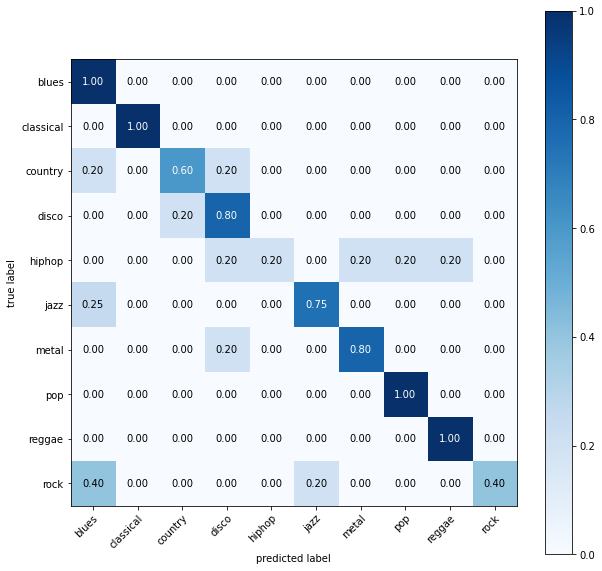

In [45]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
import re


classes = sorted([
    genres.index(re.sub(r'\d', '', c.replace(".png", ""))) 
    for c in os.listdir(test_dir + "/images/")
])
y_pred = np.argmax(predictions, axis=1)

print('Confusion Matrix')
con_mat = confusion_matrix(classes, y_pred)

fig, ax = plot_confusion_matrix(
    conf_mat=con_mat,
    colorbar=True,
    show_absolute=False,
    show_normed=True,
    figsize=(10, 10),
    class_names=genres
)

print(confusion_matrix(classes, y_pred))
print('Classification Report')
target_names = genres
print(classification_report(classes, y_pred, target_names=target_names))
print("Cohen's Kappa: {}".format(cohen_kappa_score(classes, y_pred)))
print("Accuracy: ",accuracy_score(classes, y_pred))

## Pretrained models

In [ ]:
from functools import reduce

def get_f_map_dims(shape):
  return reduce((lambda x, y: x * y), list(shape)) 


def get_file_paths_recursive(root_dir: str) -> List[str]:
  src_file_paths = []
  for genre in genres:
    for file_path in glob.glob(os.path.join(root_dir, f"{genre}", "*.png"), recursive=True):
        src_file_paths.append(file_path)
  
  return src_file_paths

In [ ]:
from typing import List
from keras.applications import VGG16, Xception, ResNet50V2, InceptionV3

input_shape = (*image_target_size, 3)

params = {
    "weights": "imagenet", 
    "include_top": False, 
    "input_shape": input_shape
}

final_feature_map_shape = None
saved_model_dir = "/content/drive/MyDrive/GTZAN/models/"

def get_conv_base(base: str, base_path: str):
  if base == "v":
    shape = (9, 13, 512)
    base_path += "VGG16/"
    conv_base = VGG16(**params)
  elif base == "x":
    shape = (9, 14, 2048)
    base_path += "Xception/"
    conv_base = Xception(**params)
  elif base == "r":
    shape = (9, 14, 2048)
    base_path += "ResNet50V2/"
    conv_base = ResNet50V2(**params)
  elif base == "i":
    shape = (7, 12, 2048)
    base_path += "InceptionV3/"
    conv_base = InceptionV3(**params)
  
  return conv_base, shape, base_path


# weights specifies the weight checkpoint from which to initialize the model.
# 
# include_top refers to including (or not) the densely connected
# classifier on top of the network. By default, this densely connected
# classifier corresponds to the 1,000 classes from ImageNet.
# 
# input_shape is the shape of the image tensors that you’ll feed to the
# network. 
conv_base, final_feature_map_shape, saved_model_dir = get_conv_base("r", saved_model_dir)

conv_base.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 288, 432, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 294, 438, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 144, 216, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

### Feature Extraction without Data Augmentation 

#### Data generators

In [ ]:
import os
import numpy as np
from typing import Set
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
WITHOUT_DA_BATCH_SIZE = 20

flatten_feature_map = get_f_map_dims(final_feature_map_shape)

# This function is extracting features on VGG16 convolutional base and returns (features, labels).
def extract_features(directory: str, sample_count: int):
  classes_count = len(genres)
  features = np.zeros(shape=(sample_count, *final_feature_map_shape))
  labels = np.zeros(shape=(sample_count, classes_count))
  
  generator = datagen.flow_from_directory(
      directory,
      target_size=image_target_size,
      batch_size=WITHOUT_DA_BATCH_SIZE,
      class_mode='categorical'
  )
  
  print("Extracting features on pretrained convolutional base...")
  i = 0
  for inputs_batch, labels_batch in generator:
    start = i * WITHOUT_DA_BATCH_SIZE
    end = (i + 1) * WITHOUT_DA_BATCH_SIZE

    print()
    features_batch = conv_base.predict(inputs_batch, verbose=2)
    print(f"{end} images predicted")

    features[start : end] = features_batch
    labels[start : end] = labels_batch
    i += 1
    if i * WITHOUT_DA_BATCH_SIZE >= sample_count:
      break
  
  return features, labels


def get_train_data_without_da():
  print("Creating train features and labels")

  images_path = gtzan_train_dir
  src_file_paths = get_file_paths_recursive(images_path)

  train_files_count = len(src_file_paths)

  train_features, train_labels = extract_features(images_path, train_files_count)
  train_features = np.reshape(train_features, (train_files_count, flatten_feature_map))

  return train_features, train_labels

def get_validation_data_without_da():
  print("Creating validation features and labels")

  images_path = gtzan_val_dir
  src_file_paths = get_file_paths_recursive(images_path)

  val_files_count = len(src_file_paths)
  
  validation_features, validation_labels = extract_features(images_path, val_files_count)
  validation_features = np.reshape(validation_features, (val_files_count, flatten_feature_map))

  return validation_features, validation_labels

def get_test_data_generator():
  print("Creating test data generator")

  images_path = gtzan_test_dir
  src_file_paths = get_file_paths_recursive(images_path)

  test_files_count = len(src_file_paths)
  
  test_features, test_labels = extract_features(images_path, test_files_count)
  test_features = np.reshape(test_features, (test_files_count, flatten_feature_map))

  return test_features

#### Model

In [ ]:
def build_model_without_da() -> Sequential:
  
  model = models.Sequential()

  model.add(layers.Dense(512, activation='relu', input_dim=flatten_feature_map))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(10, activation='softmax'))
  
  model.compile(
      optimizer=optimizers.RMSprop(lr=2e-5),
      loss=losses.categorical_crossentropy,
      metrics=[metrics.categorical_accuracy]
  )

  return model

#### Fit

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Creating train features and labels
Found 850 images belonging to 10 classes.
Extracting features on pretrained convolutional base...

1/1 - 10s - 10s/epoch - 10s/step
20 images predicted

1/1 - 0s - 41ms/epoch - 41ms/step
40 images predicted

1/1 - 0s - 39ms/epoch - 39ms/step
60 images predicted

1/1 - 0s - 42ms/epoch - 42ms/step
80 images predicted

1/1 - 0s - 38ms/epoch - 38ms/step
100 images predicted

1/1 - 0s - 39ms/epoch - 39ms/step
120 images predicted

1/1 - 0s - 40ms/epoch - 40ms/step
140 images predicted

1/1 - 0s - 38ms/epoch - 38ms/step
160 images predicted

1/1 - 0s - 39ms/epoch - 39ms/step
180 images predicted

1/1 - 0s - 39ms/epoch - 39ms/step
200 images predicted

1/1 - 0s - 28ms/epoch - 28ms/step
220 images predicted

1/1 - 0s - 27ms/epoch - 27ms/step
240 images predicted

1/1 - 0s - 30ms/epoch - 30ms/step
260 images predicted

1/1 - 0s - 29ms/epoch - 29ms/step
280 images predicted

1/1 - 0s - 28ms/epoch - 28ms/step
300 images predicted

1/1 - 0s - 28ms/epoch - 28ms/st

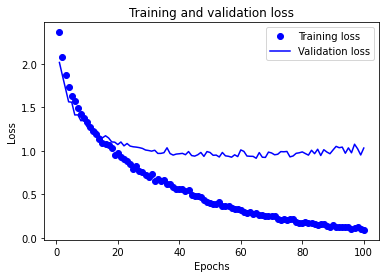

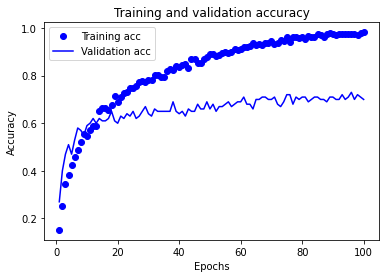

In [ ]:
# def fit_model(model, x, y, train_steps, epochs, validation_data, validation_steps, model_path):
model_without_da = build_model_without_da() 

train_features, train_labels = get_train_data_without_da()
val_data = get_validation_data_without_da()

train_images_count = len(get_file_paths_recursive(gtzan_train_dir))
val_images_count = len(get_file_paths_recursive(gtzan_val_dir))

train_steps = train_images_count / WITHOUT_DA_BATCH_SIZE
val_steps = val_images_count / WITHOUT_DA_BATCH_SIZE

model_without_da_path = saved_model_dir + "feature_extraction/without_data_augmentation.h5"

EPOCHS = 100

fit_model(
    model=model_without_da, 
    x=train_features, 
    y=train_labels,
    train_steps=train_steps,
    epochs=EPOCHS,
    validation_data=val_data,
    validation_steps=val_steps,
    model_path=model_without_da_path
)

#### Evaluate

In [ ]:
# def evaluate_model(train_x, train_y, val_x, val_y):

evaluate_model(
    model=model_without_da,
    train_x=train_features, 
    train_y=train_labels, 
    val_x=val_data[0], 
    val_y=val_data[1]
)

Train loss: 0.0208
Train accuracy: 0.9988
Validation loss: 1.0328
Validation accuracy: 0.7


#### Predict

### Feature Extraction with Data Augmentation

#### Data generators

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

# BATCH_SIZE = 128
WITH_DA_BATCH_SIZE = 20
target_size = image_target_size

def get_train_data_generator_with_da() -> DirectoryIterator:
  print("Creating train data generator")

  train_dir = train_dir_on_colab_instance
  
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir, 
      target_size=target_size, 
      batch_size=WITH_DA_BATCH_SIZE, 
      class_mode="categorical"
  )

  return train_generator


def get_validation_data_generator_with_da() -> DirectoryIterator:
  print("Creating validation data generator")
  validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

  validation_dir = val_dir_on_colab_instance

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir, 
      target_size=target_size, 
      batch_size=WITH_DA_BATCH_SIZE, 
      class_mode="categorical",  
      shuffle = False
  )
  return validation_generator

#### Model

In [ ]:
def build_model_with_da() -> Sequential:
  
  model = models.Sequential()

  model.add(conv_base)

  model.add(layers.Flatten())

  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(10, activation='softmax'))
  
  model.compile(
      optimizer=optimizers.RMSprop(lr=2e-5),
      loss=losses.categorical_crossentropy,
      metrics=[metrics.categorical_accuracy]
  )

  return model

#### Fit

Creating train data generator
Found 850 images belonging to 10 classes.
Creating validation data generator
Found 100 images belonging to 10 classes.
Epoch 1/80
42/42 [==============================] - 49s 967ms/step - loss: 2.3976 - categorical_accuracy: 0.1329 - val_loss: 2.1518 - val_categorical_accuracy: 0.2400
Epoch 2/80
42/42 [==============================] - 38s 892ms/step - loss: 2.1837 - categorical_accuracy: 0.2024 - val_loss: 1.9522 - val_categorical_accuracy: 0.3600
Epoch 3/80
42/42 [==============================] - 38s 877ms/step - loss: 2.0619 - categorical_accuracy: 0.2353 - val_loss: 1.7931 - val_categorical_accuracy: 0.3800
Epoch 4/80
42/42 [==============================] - 38s 877ms/step - loss: 1.9129 - categorical_accuracy: 0.3106 - val_loss: 1.5933 - val_categorical_accuracy: 0.4300
Epoch 5/80
42/42 [==============================] - 38s 880ms/step - loss: 1.7656 - categorical_accuracy: 0.3682 - val_loss: 1.7433 - val_categorical_accuracy: 0.3200
Epoch 6/80
42/42

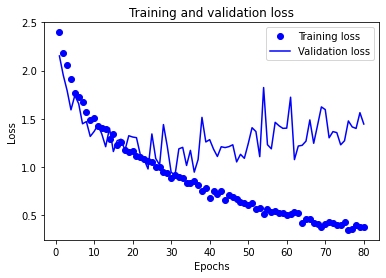

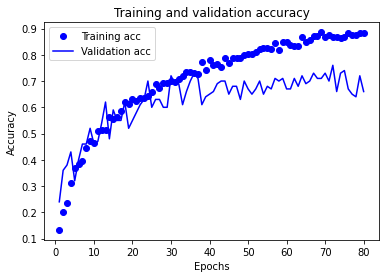

In [ ]:
# def fit_model(model, x, y, train_steps, epochs, validation_data, validation_steps, model_path):
model_with_da = build_model_with_da() 

train_data = get_train_data_generator_with_da()
val_data = get_validation_data_generator_with_da()

train_steps = train_data.samples / train_data.batch_size
val_steps = val_data.samples / val_data.batch_size

model_with_da_path = saved_model_dir + "feature_extraction/with_data_augmentation.h5"

EPOCHS = 80

fit_model(
    model=model_with_da, 
    x=train_data, 
    y=None,
    train_steps=train_steps,
    epochs=EPOCHS,
    validation_data=val_data,
    validation_steps=val_steps,
    model_path=model_with_da_path
)

#### Evaluate

In [ ]:
# def evaluate_model(train_x, train_y, val_x, val_y):

evaluate_model(
    model=model_with_da,
    train_x=train_data, 
    train_y=None, 
    val_x=val_data, 
    val_y=None
)

Train loss: 0.2132
Train accuracy: 0.9306
Validation loss: 1.4464
Validation accuracy: 0.66


#### Predict

In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

test_dir = gtzan_test_dir
test_datagen = ImageDataGenerator(rescale=1./255)

# shuffle=False in order to preserve the order of filenames and predictions.
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=image_target_size,
    color_mode="rgb",
    class_mode=None,
    shuffle=False,
    seed=42
)

predictions = model_with_da.predict(
    test_generator,
)

predicted_class_indices=np.argmax(predictions,axis=1)
labels = genres
# labels = train_data.class_indices
# labels = dict((v,k) for k,v in labels.items())
prediction_results = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                      "Predictions": prediction_results})
print(results)

Found 49 images belonging to 1 classes.
2/2 [==============================] - 12s 3s/step
                     Filename Predictions
0       images/blues00009.png       blues
1       images/blues00032.png       blues
2       images/blues00056.png        rock
3       images/blues00073.png     country
4       images/blues00080.png       blues
5   images/classical00009.png   classical
6   images/classical00029.png   classical
7   images/classical00057.png   classical
8   images/classical00065.png   classical
9   images/classical00078.png   classical
10    images/country00021.png     country
11    images/country00055.png        rock
12    images/country00080.png     country
13    images/country00083.png     country
14    images/country00097.png     country
15      images/disco00001.png       disco
16      images/disco00043.png         pop
17      images/disco00056.png         pop
18      images/disco00068.png       disco
19      images/disco00082.png       disco
20     images/hiphop00014.p

Confusion Matrix
[[3 0 1 0 0 0 0 0 0 1]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 1]
 [0 0 0 3 0 0 0 2 0 0]
 [0 0 0 0 3 0 1 1 0 0]
 [0 0 0 0 0 3 0 1 0 0]
 [0 0 0 0 0 0 4 0 0 1]
 [2 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 2 0 0 1 2 0]
 [1 0 0 1 0 0 0 2 0 1]]
Classification Report
              precision    recall  f1-score   support

       blues       0.50      0.60      0.55         5
   classical       1.00      1.00      1.00         5
     country       0.80      0.80      0.80         5
       disco       0.75      0.60      0.67         5
      hiphop       0.60      0.60      0.60         5
        jazz       1.00      0.75      0.86         4
       metal       0.80      0.80      0.80         5
         pop       0.30      0.60      0.40         5
      reggae       1.00      0.40      0.57         5
        rock       0.25      0.20      0.22         5

    accuracy                           0.63        49
   macro avg       0.70      0.64      0.65        49
weighted avg       0.69   

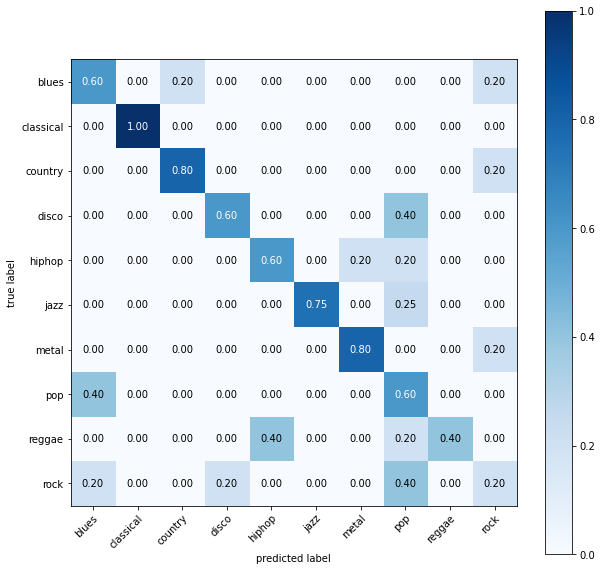

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
import re


classes = sorted([
    genres.index(re.sub(r'\d', '', c.replace(".png", ""))) 
    for c in os.listdir(test_dir + "/images/")
])
y_pred = np.argmax(predictions, axis=1)

print('Confusion Matrix')
con_mat = confusion_matrix(classes, y_pred)

fig, ax = plot_confusion_matrix(
    conf_mat=con_mat,
    colorbar=True,
    show_absolute=False,
    show_normed=True,
    figsize=(10, 10),
    class_names=genres
)

print(confusion_matrix(classes, y_pred))
print('Classification Report')
target_names = genres
print(classification_report(classes, y_pred, target_names=target_names))
print("Cohen's Kappa: {}".format(cohen_kappa_score(classes, y_pred)))
print("Accuracy: ",accuracy_score(classes, y_pred))

### Fine Tuning

#### Data generators

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

# BATCH_SIZE = 128
FINE_TUNING_BATCH_SIZE = 20

flatten_feature_map = get_f_map_dims(final_feature_map_shape)

def get_train_data_generator_fine_tuning() -> DirectoryIterator:
  print("Creating train data generator")

  train_dir = train_dir_on_colab_instance
  target_size = image_target_size
  
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir, 
      target_size=target_size, 
      batch_size=FINE_TUNING_BATCH_SIZE, 
      class_mode="categorical"
  )

  return train_generator


def get_validation_data_generator_fine_tuning() -> DirectoryIterator:
  print("Creating validation data generator")
  validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

  validation_dir = val_dir_on_colab_instance
  target_size = image_target_size

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir, 
      target_size=target_size, 
      batch_size=FINE_TUNING_BATCH_SIZE, 
      class_mode="categorical",  
      shuffle = False
  )
  return validation_generator

#### Model

In [ ]:
def build_model_fine_tuning() -> Sequential:
  
  conv_base_fine_tuning = conv_base
  conv_base_fine_tuning.trainable = True

# FOR RESNET
  for layer in conv_base_fine_tuning.layers[:175]:
    layer.trainable = False
    
  for layer in conv_base_fine_tuning.layers[175:]:
    layer.trainable = True

  # set_trainable = False
  # for layer in conv_base_fine_tuning.layers:
  #   if layer.name == 'conv5_block3_3_conv':
  #     set_trainable = True
  #   if set_trainable:
  #     layer.trainable = True
  #   else:
  #     layer.trainable = False

  
  model = models.Sequential()

  model.add(conv_base_fine_tuning)

  model.add(layers.Flatten())

  model.add(layers.Dense(512, activation='relu', input_dim=flatten_feature_map))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(10, activation='softmax'))
  
  model.compile(
      optimizer=optimizers.RMSprop(learning_rate=1e-5),
      loss=losses.categorical_crossentropy,
      metrics=[metrics.categorical_accuracy]
  )

  return model

#### Fit

In [ ]:
# def fit_model(model, x, y, train_steps, epochs, validation_data, validation_steps, model_path):
model_fine_tuning = build_model_fine_tuning() 

train_data = get_train_data_generator_fine_tuning()
val_data = get_validation_data_generator_fine_tuning()

train_steps = train_data.samples / train_data.batch_size
val_steps = val_data.samples / val_data.batch_size

model_with_fine_tuning_path = saved_model_dir +  "fine_tuning.h5"

EPOCHS = 50

fit_model(
    model=model_fine_tuning, 
    x=train_data, 
    y=None,
    train_steps=train_steps,
    epochs=EPOCHS,
    validation_data=val_data,
    validation_steps=val_steps,
    model_path=model_with_fine_tuning_path
)

Creating train data generator
Found 850 images belonging to 10 classes.
Creating validation data generator
Found 100 images belonging to 10 classes.
Epoch 1/50
42/42 [==============================] - 36s 734ms/step - loss: 3.3268 - categorical_accuracy: 0.1141 - val_loss: 2.3041 - val_categorical_accuracy: 0.1300
Epoch 2/50
42/42 [==============================] - 30s 698ms/step - loss: 2.7764 - categorical_accuracy: 0.1459 - val_loss: 2.1598 - val_categorical_accuracy: 0.2800
Epoch 3/50
42/42 [==============================] - 30s 701ms/step - loss: 2.6123 - categorical_accuracy: 0.1447 - val_loss: 2.1247 - val_categorical_accuracy: 0.2400
Epoch 4/50
42/42 [==============================] - 30s 699ms/step - loss: 2.3932 - categorical_accuracy: 0.1918 - val_loss: 2.0442 - val_categorical_accuracy: 0.3000
Epoch 5/50
42/42 [==============================] - 30s 709ms/step - loss: 2.3374 - categorical_accuracy: 0.2106 - val_loss: 2.0151 - val_categorical_accuracy: 0.2500
Epoch 6/50
42/42

KeyboardInterrupt: ignored

#### Evaluate

In [ ]:
# def evaluate_model(train_x, train_y, val_x, val_y):

evaluate_model(
    model=model_fine_tuning,
    train_x=train_data, 
    train_y=None, 
    val_x=val_data, 
    val_y=None
)

#### Predict

In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

test_dir = gtzan_test_dir
test_datagen = ImageDataGenerator(rescale=1./255)

# shuffle=False in order to preserve the order of filenames and predictions.
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=image_target_size,
    color_mode="rgb",
    class_mode=None,
    shuffle=False,
    seed=42
)

predictions = model_fine_tuning.predict(
    test_generator,
)

predicted_class_indices=np.argmax(predictions,axis=1)
labels = genres
# labels = train_data.class_indices
# labels = dict((v,k) for k,v in labels.items())
prediction_results = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                      "Predictions": prediction_results})
print(results)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
import re


classes = sorted([
    genres.index(re.sub(r'\d', '', c.replace(".png", ""))) 
    for c in os.listdir(test_dir + "/images/")
])
y_pred = np.argmax(predictions, axis=1)

print('Confusion Matrix')
con_mat = confusion_matrix(classes, y_pred)

fig, ax = plot_confusion_matrix(
    conf_mat=con_mat,
    colorbar=True,
    show_absolute=False,
    show_normed=True,
    figsize=(10, 10),
    class_names=genres
)

print(confusion_matrix(classes, y_pred))
print('Classification Report')
target_names = genres
print(classification_report(classes, y_pred, target_names=target_names))
print("Cohen's Kappa: {}".format(cohen_kappa_score(classes, y_pred)))
print("Accuracy: ",accuracy_score(classes, y_pred))

# Results

### My network
#### Results on 3 sec spectograms: 
- Train loss: 0.0192
- Train accuracy: 0.9945
- Validation loss: 0.8952
- Validation accuracy: 0.7120





#### Provided spectograms (Mel spectograms)

Sample spectogram

<img src="https://drive.google.com/uc?id=1r2SntIc1ENKZShA6HkalgWoUaLOi3Pfp">

- Train loss: 0.0642
- Train accuracy: 0.9929
- Validation loss: 1.4712
- Validation accuracy: 0.65


<img src='https://drive.google.com/uc?id=1c06cDs54OygpZH0ErjiT0PI_Dl_5--qn'>
<img src='https://drive.google.com/uc?id=13WdPx6f7-ck-8s2odEfMRbjlvt6k9H4I'>


```
Classification Report
              precision    recall  f1-score   support

       blues       0.50      0.60      0.55         5
   classical       0.71      1.00      0.83         5
     country       0.50      0.80      0.62         5
       disco       1.00      0.20      0.33         5
      hiphop       0.67      0.80      0.73         5
        jazz       0.40      0.50      0.44         4
       metal       1.00      0.80      0.89         5
         pop       0.80      0.80      0.80         5
      reggae       0.80      0.80      0.80         5
        rock       1.00      0.40      0.57         5

    accuracy                           0.67        49
   macro avg       0.74      0.67      0.66        49
weighted avg       0.74      0.67      0.66        49

Cohen's Kappa: 0.6372049976862565
Accuracy:  0.673469387755102
```

<img src='https://drive.google.com/uc?id=1CTRajOd_R3rdZr-3Mh0D68wI1GsNxwKA'>


#### Mel-scaled - 30 sec songs

Sample spectogram

<img src='https://drive.google.com/uc?id=1RR1h8VdP9vE21xjFBV4oDzvDdnEY3jUY'>


- Train loss: 0.0874
- Train accuracy: 0.9812
- Validation loss: 1.311
- Validation accuracy: 0.61

<img src='https://drive.google.com/uc?id=1Bw1HOGc0qwczXO0Uaii9-QJ2cBS3Um-i'>

<img src='https://drive.google.com/uc?id=1xi2fxeGS0DAUqUgFYDTENrvOP4v4G4Gq'>

```
Classification Report
              precision    recall  f1-score   support

       blues       0.56      1.00      0.71         5
   classical       1.00      1.00      1.00         5
     country       0.75      0.60      0.67         5
       disco       0.57      0.80      0.67         5
      hiphop       1.00      0.20      0.33         5
        jazz       0.75      0.75      0.75         4
       metal       0.80      0.80      0.80         5
         pop       0.83      1.00      0.91         5
      reggae       0.83      1.00      0.91         5
        rock       1.00      0.40      0.57         5

    accuracy                           0.76        49
   macro avg       0.81      0.76      0.73        49
weighted avg       0.81      0.76      0.73        49

Cohen's Kappa: 0.7277777777777779
Accuracy:  0.7551020408163265
```

<img src='https://drive.google.com/uc?id=121QuZGeOiQciKzD6okvhyE6QvzdOHiv4'>



#### Constant-Q transform - 30 sec songs

Sample spectogram

<img src='https://drive.google.com/uc?id=1_1ui7rtL2irOo1214yG_bQGs5J-GvBuF'>

- Train loss: 0.0268
- Train accuracy: 0.9988
- Validation loss: 1.6469
- Validation accuracy: 0.64

<img src='https://drive.google.com/uc?id=1eBOkz5rXA9iFHqjXWXTEEtvqgX4T5mKq'>
<img src='https://drive.google.com/uc?id=1sYR66uXSHvxcwFwuW5CEpML_zJ1mQqU2'>

```
Classification Report
              precision    recall  f1-score   support

       blues       0.60      0.60      0.60         5
   classical       0.71      1.00      0.83         5
     country       0.50      0.20      0.29         5
       disco       0.60      0.60      0.60         5
      hiphop       1.00      0.60      0.75         5
        jazz       1.00      0.50      0.67         4
       metal       0.67      0.80      0.73         5
         pop       0.43      0.60      0.50         5
      reggae       0.50      0.60      0.55         5
        rock       0.50      0.60      0.55         5

    accuracy                           0.61        49
   macro avg       0.65      0.61      0.61        49
weighted avg       0.64      0.61      0.60        49

Cohen's Kappa: 0.5685820203892494
Accuracy:  0.6122448979591837
```

<img src='https://drive.google.com/uc?id=1_aTL85pWwjdXZnK4brtfGkTNgPTxNqOX'>



#### Variable-Q transform - 30 sec songs

Sample spectogram

<img src='https://drive.google.com/uc?id=1qh9HCD1yY3Mz7plc1J4WfC7bRWMdxtB_'>


- Train loss: 0.044
- Train accuracy: 0.9976
- Validation loss: 1.3945
- Validation accuracy: 0.68


<img src='https://drive.google.com/uc?id=1PF1VVEL2k5kB46n0KTA_ydnwaMgz1qO2'>

<img src='https://drive.google.com/uc?id=1kySLY72DpOk9lSFHDqVLpyDJDpNNAPxy'>


```
Classification Report
              precision    recall  f1-score   support

       blues       0.50      0.60      0.55         5
   classical       0.75      0.60      0.67         5
     country       0.75      0.60      0.67         5
       disco       0.67      0.80      0.73         5
      hiphop       1.00      0.60      0.75         5
        jazz       0.75      0.75      0.75         4
       metal       0.50      0.80      0.62         5
         pop       0.67      0.80      0.73         5
      reggae       0.67      0.40      0.50         5
        rock       0.80      0.80      0.80         5

    accuracy                           0.67        49
   macro avg       0.70      0.68      0.67        49
weighted avg       0.70      0.67      0.67        49

Cohen's Kappa: 0.6370370370370371
Accuracy:  0.673469387755102
```

<img src='https://drive.google.com/uc?id=1w0RC5nuE41mvYoroC6F2TbEt5gXaLTFx'>



#### Semitone spectrogram (IIRT) - 30 sec songs
 
Sample spectogram

<img src='https://drive.google.com/uc?id=1Nq8CJmrS2opPHdJHrQopobnaVxMlYPFK'>

- Train loss: 0.0127
- Train accuracy: 1.0
- Validation loss: 1.7951
- Validation accuracy: 0.66

<img src='https://drive.google.com/uc?id=1Qe3sx-cavJalNQ6FBEcOjnhmQpB1oc1T'>
<img src='https://drive.google.com/uc?id=1KB5YCHVVNeF5GtiKsAaP1eiuTd_1qrE-'>

```
Classification Report
              precision    recall  f1-score   support

       blues       0.83      1.00      0.91         5
   classical       1.00      1.00      1.00         5
     country       0.50      0.60      0.55         5
       disco       0.67      0.40      0.50         5
      hiphop       1.00      0.40      0.57         5
        jazz       1.00      0.75      0.86         4
       metal       1.00      0.80      0.89         5
         pop       0.40      0.80      0.53         5
      reggae       0.50      0.40      0.44         5
        rock       0.50      0.60      0.55         5

    accuracy                           0.67        49
   macro avg       0.74      0.68      0.68        49
weighted avg       0.73      0.67      0.68        49

Cohen's Kappa: 0.6368689207966652
Accuracy:  0.673469387755102
```

<img src='https://drive.google.com/uc?id=1YaK8eKbz-y3vdooqj2I3eYnxwJTT2V61'>



#### Short-time Fourier transform (STFT) - 30 sec songs

Sample spectogram

<img src='https://drive.google.com/uc?id=1B0QPejXRoCQovGFnTmtSJ8yRFY8LZRGi'>


- Train loss: 0.2167
- Train accuracy: 0.9494
- Validation loss: 1.4196
- Validation accuracy: 0.61

<img src='https://drive.google.com/uc?id=1G7JYGWC3APjPDpotQjqji4O_pyK-Q1B6'>
<img src='https://drive.google.com/uc?id=1Rn6ck4eop1vEdWwTs7REHW69AG3aRQ5T'>

```
Classification Report
              precision    recall  f1-score   support

       blues       0.67      0.80      0.73         5
   classical       0.83      1.00      0.91         5
     country       0.50      0.60      0.55         5
       disco       0.33      0.20      0.25         5
      hiphop       0.67      0.40      0.50         5
        jazz       0.75      0.75      0.75         4
       metal       0.67      0.80      0.73         5
         pop       1.00      1.00      1.00         5
      reggae       0.75      0.60      0.67         5
        rock       0.83      1.00      0.91         5

    accuracy                           0.71        49
   macro avg       0.70      0.72      0.70        49
weighted avg       0.70      0.71      0.70        49

Cohen's Kappa: 0.6824074074074075
Accuracy:  0.7142857142857143
```

<img src='https://drive.google.com/uc?id=1E2q__apa3EysMrH9dBwZh7AzS_v9MkCS'>




#### Chromagram from a waveform or power spectrogram - 30 sec songs

Sample chromagram

<img src='https://drive.google.com/uc?id=1aGh5QvfZqwyo7tkGBZdQYOgqB77aO-jD'>

- Train loss: 0.001
- Train accuracy: 1.0
- Validation loss: 7.4194
- Validation accuracy: 0.31

<img src='https://drive.google.com/uc?id=1_Jt_8HbYgEHmeQfQbV13h2O9mDbQqQSY'>

<img src='https://drive.google.com/uc?id=15NMKlC0Ai4aEPtni_B11eMyDzgLZI5CF'>


```
Classification Report
              precision    recall  f1-score   support

       blues       1.00      0.20      0.33         5
   classical       0.60      0.60      0.60         5
     country       0.20      0.40      0.27         5
       disco       0.75      0.60      0.67         5
      hiphop       0.80      0.80      0.80         5
        jazz       0.33      0.75      0.46         4
       metal       0.33      0.20      0.25         5
         pop       0.43      0.60      0.50         5
      reggae       1.00      0.40      0.57         5
        rock       0.33      0.20      0.25         5

    accuracy                           0.47        49
   macro avg       0.58      0.48      0.47        49
weighted avg       0.58      0.47      0.47        49

Cohen's Kappa: 0.4115473441108545
Accuracy:  0.46938775510204084
```

<img src='https://drive.google.com/uc?id=1h2OQC1OYWJ5rb2rd0t-u4B32qVi_BGjN'>


### VGG16
#### Feature extraction without Data Augmentation
- Train loss: 0.0208
- Train accuracy: 0.9988
- Validation loss: 1.0328
- Validation accuracy: 0.7

<img src='https://drive.google.com/uc?id=1GGV39xn6k6k_qgSk4rLUhUC2-HlYDP0Q'>
<img src='https://drive.google.com/uc?id=1Iv0_j3w1Q3dsIP6awhO8phoAEbsst80X'>


#### Feature extraction with Data Augmentation
- Train loss: 0.2132
- Train accuracy: 0.9306
- Validation loss: 1.4464
- Validation accuracy: 0.66

<img src='https://drive.google.com/uc?id=1yiuh5Y85SXkV9tE1UmLawa1CUUIFGNOL'>
<img src='https://drive.google.com/uc?id=1m69FSKVpRV9Pb3Sw8ihZ8_JtlEDsAZvw'>

```
Classification Report
              precision    recall  f1-score   support

       blues       0.50      0.60      0.55         5
   classical       1.00      1.00      1.00         5
     country       0.80      0.80      0.80         5
       disco       0.75      0.60      0.67         5
      hiphop       0.60      0.60      0.60         5
        jazz       1.00      0.75      0.86         4
       metal       0.80      0.80      0.80         5
         pop       0.30      0.60      0.40         5
      reggae       1.00      0.40      0.57         5
        rock       0.25      0.20      0.22         5

    accuracy                           0.63        49
   macro avg       0.70      0.64      0.65        49
weighted avg       0.69      0.63      0.64        49

Cohen's Kappa: 0.5914775358962482
Accuracy:  0.6326530612244898
```

<img src='https://drive.google.com/uc?id=1n5iOobxGc1hSXl6NePZoYcu-e_HRxPSl'>

#### Feature extraction with Fine Tuning
- Train loss: 0.336
- Train accuracy: 0.8894
- Validation loss: 1.1155
- Validation accuracy: 0.69

<img src='https://drive.google.com/uc?id=13c5S5Nmj5UJl9bjVGS2M2P5cCy7w1JFm'>
<img src='https://drive.google.com/uc?id=1bb4u6LYjDVQYMzTYqi_9q9DQvs8p9URO'>


```
Classification Report
              precision    recall  f1-score   support

       blues       0.67      0.80      0.73         5
   classical       1.00      0.80      0.89         5
     country       0.75      0.60      0.67         5
       disco       0.50      0.60      0.55         5
      hiphop       0.67      0.80      0.73         5
        jazz       0.57      1.00      0.73         4
       metal       1.00      0.60      0.75         5
         pop       0.29      0.40      0.33         5
      reggae       0.50      0.40      0.44         5
        rock       0.50      0.20      0.29         5

    accuracy                           0.61        49
   macro avg       0.64      0.62      0.61        49
weighted avg       0.65      0.61      0.61        49

Cohen's Kappa: 0.5695792880258901
Accuracy:  0.6122448979591837
```

<img src='https://drive.google.com/uc?id=1Ba3A2g5DCzWCf968lGezjhxC40xG_fyn'>

### Xception
#### Feature extraction without Data Augmentation
- Train loss: 0.0008
- Train accuracy: 1.0
- Validation loss: 1.2818
- Validation accuracy: 0.73


<img src='https://drive.google.com/uc?id=1_4qqYUq8EoY8uo1YiVGdY1n5xEJlTtZh'>
<img src='https://drive.google.com/uc?id=16et6BoQ-CAX9k0KAflKAO1uYs3G6-0yR'>


#### Feature extraction with Data Augmentation
- Train loss: 0.0437
- Train accuracy: 0.9835
- Validation loss: 1.5452
- Validation accuracy: 0.76


<img src='https://drive.google.com/uc?id=1kCaN_CGZrBbjBvp9Rr5HrO01EUAsPEcW'>
<img src='https://drive.google.com/uc?id=16R2gBLA4rJNYDuCnQqWrRjQlxc-8-6ey'>


Classification Report
```
              precision    recall  f1-score   support

       blues       0.80      0.80      0.80         5
   classical       0.83      1.00      0.91         5
     country       1.00      0.60      0.75         5
       disco       1.00      1.00      1.00         5
      hiphop       1.00      0.60      0.75         5
        jazz       0.80      1.00      0.89         4
       metal       0.83      1.00      0.91         5
         pop       0.57      0.80      0.67         5
      reggae       0.80      0.80      0.80         5
        rock       0.75      0.60      0.67         5

    accuracy                           0.82        49
   macro avg       0.84      0.82      0.81        49
weighted avg       0.84      0.82      0.81        49


Cohen's Kappa: 0.7959278111985193
Accuracy:  0.8163265306122449
```

<img src='https://drive.google.com/uc?id=17A9rIM8j0k4-saGcKIhzh80DFfivFjCw'>


#### Feature extraction with Fine Tuning

- Train loss: 0.0267
- Train accuracy: 0.9906
- Validation loss: 1.9151
- Validation accuracy: 0.78


<img src='https://drive.google.com/uc?id=1pX0Ir9PifNjF6Utz_JO4-iP5krVgKjsN'>
<img src='https://drive.google.com/uc?id=1n4Qt30XwsfZ5IjqiyxdgiUleDUQZtzVk'>


```
Classification Report
              precision    recall  f1-score   support

       blues       0.80      0.80      0.80         5
   classical       0.83      1.00      0.91         5
     country       0.75      0.60      0.67         5
       disco       1.00      1.00      1.00         5
      hiphop       1.00      0.60      0.75         5
        jazz       0.80      1.00      0.89         4
       metal       0.83      1.00      0.91         5
         pop       0.57      0.80      0.67         5
      reggae       0.80      0.80      0.80         5
        rock       0.67      0.40      0.50         5

    accuracy                           0.80        49
   macro avg       0.81      0.80      0.79        49
weighted avg       0.81      0.80      0.79        49

Cohen's Kappa: 0.7732531235539103
Accuracy:  0.7959183673469388
```

<img src='https://drive.google.com/uc?id=1FpFpuy3ZE-3aEtiRAMeDX0JaxnLaT67X'>

### ResNet50V2

#### Feature extraction without Data Augmentation

- Train loss: 0.0
- Train accuracy: 1.0
- Validation loss: 1.6424
- Validation accuracy: 0.74


<img src='https://drive.google.com/uc?id=1LsOTFkcH4wPt--gE-nHMAkDxK981ltpf'>
<img src='https://drive.google.com/uc?id=1hNb2iiUgoos1aMcXP0XhJ7RZkeIP0SRK'>


#### Feature extraction with Data Augmentation

- Train loss: 0.1062
- Train accuracy: 0.9671
- Validation loss: 1.4012
- Validation accuracy: 0.76


<img src='https://drive.google.com/uc?id=1lLOivC4FZ8FSEILxKkdeQ9TFOmGAnAZI'>
<img src='https://drive.google.com/uc?id=1BgSGVoZSZm0MWPIss-iMsR1pCctZuI_z'>


```
Classification Report
              precision    recall  f1-score   support

       blues       0.80      0.80      0.80         5
   classical       0.83      1.00      0.91         5
     country       0.75      0.60      0.67         5
       disco       1.00      1.00      1.00         5
      hiphop       1.00      0.60      0.75         5
        jazz       0.80      1.00      0.89         4
       metal       0.83      1.00      0.91         5
         pop       0.57      0.80      0.67         5
      reggae       0.80      0.80      0.80         5
        rock       0.67      0.40      0.50         5

    accuracy                           0.80        49
   macro avg       0.81      0.80      0.79        49
weighted avg       0.81      0.80      0.79        49

Cohen's Kappa: 0.7732531235539103
Accuracy:  0.7959183673469388
```


<img src='https://drive.google.com/uc?id=1y3cqdAYQkl7i08vCX3Sso891l-oaD44P'>



#### Feature extraction with Fine Tuning


### InceptionV3

#### Feature extraction without Data Augmentation

- Train loss: 0.0017
- Train accuracy: 0.9988
- Validation loss: 1.4355
- Validation accuracy: 0.76


<img src='https://drive.google.com/uc?id=1delrDCs7q0A4O5CHNyEQ7Q_OPbnLVKB1'>
<img src='https://drive.google.com/uc?id=1cd2VMHt5GM09uRNiUvUTQTZsEbPTdA17'>


#### Feature extraction with Data Augmentation

- Train loss: 0.2032
- Train accuracy: 0.9388
- Validation loss: 1.1643
- Validation accuracy: 0.77


<img src='https://drive.google.com/uc?id=1eKN5PvONAM4eAtaJjsB7HDQJTM0OLhHF'>
<img src='https://drive.google.com/uc?id=1QXChxMwAuzIkKmADKK8dSfvm8ahStXUw'>


```
Classification Report
              precision    recall  f1-score   support

       blues       0.75      0.60      0.67         5
   classical       1.00      1.00      1.00         5
     country       0.83      1.00      0.91         5
       disco       0.50      0.60      0.55         5
      hiphop       0.57      0.80      0.67         5
        jazz       0.80      1.00      0.89         4
       metal       0.80      0.80      0.80         5
         pop       0.67      0.40      0.50         5
      reggae       0.67      0.40      0.50         5
        rock       0.60      0.60      0.60         5

    accuracy                           0.71        49
   macro avg       0.72      0.72      0.71        49
weighted avg       0.72      0.71      0.70        49

Cohen's Kappa: 0.6825543729754743
Accuracy:  0.7142857142857143
```


<img src='https://drive.google.com/uc?id=17-OOzJkCdMAKKYgycX6wkS-lzL-voEIc'>



### Feature extraction with Fine Tuning

# Acoustic Features from GTZAN

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import pandas as pd
import sklearn.model_selection as skms

In [ ]:
features_30_sec_path = "/content/drive/MyDrive/GTZAN/Features/features_30_sec.csv"
features_3_sec_path = "/content/drive/MyDrive/GTZAN/Features/features_3_sec.csv"

## Machine learning

In [ ]:
import pandas as pydub

gtzan_data = pd.read_csv(features_3_sec_path)
gtzan_data = gtzan_data.iloc[0:, 1:] 
gtzan_data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
y = gtzan_data['label'] # genre variable.
X = gtzan_data.loc[:, gtzan_data.columns != 'label'] #select all columns but not the labels

#### NORMALIZE X ####

# Normalize to have everything is on the same scale. 

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Creating a Predefined function to assess the accuracy of a model

In [ ]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    # print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

### Trying different models to assess their performance

In [ ]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', max_iter=1000, alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Naive Bayes : 0.51952 

Accuracy Stochastic Gradient Descent : 0.65532 

Accuracy KNN : 0.80581 

Accuracy Decission trees : 0.64097 

Accuracy Random Forest : 0.81415 

Accuracy Support Vector Machine : 0.75409 

Accuracy Logistic Regression : 0.6957 



/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy Neural Nets : 0.84284 

Accuracy Cross Gradient Booster : 0.87988 

Accuracy Cross Gradient Booster (Random Forest) : 0.58859 



### Final Model

Accuracy : 0.87988 



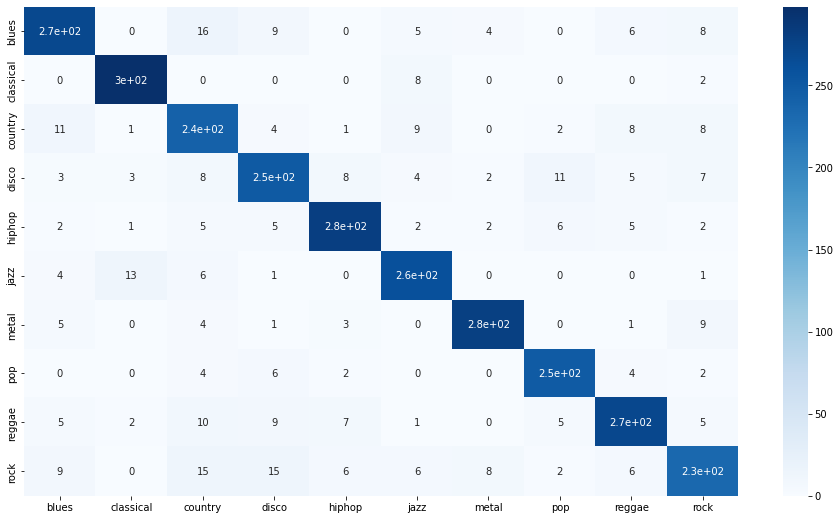

In [ ]:
import seaborn as sns

xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)

genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(
    confusion_matr, cmap="Blues", annot=True, 
    xticklabels=genres,
    yticklabels=genres
)
plt.savefig("conf matrix")

### Feature Importance

In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator=xgb, random_state=1)
perm.fit(X_test, y_test)

eli5.show_weights(estimator=perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0902 ± 0.0090,perceptr_var
0.0493 ± 0.0067,perceptr_mean
0.0486 ± 0.0058,harmony_mean
0.0388 ± 0.0051,mfcc4_mean
0.0334 ± 0.0036,chroma_stft_mean
0.0266 ± 0.0038,harmony_var
0.0263 ± 0.0048,rms_var
0.0226 ± 0.0048,mfcc9_mean
0.0204 ± 0.0030,tempo
0.0187 ± 0.0037,mfcc11_mean


## Deep learning

In [ ]:
seed = 12
np.random.seed(seed)

df = pd.read_csv(features_30_sec_path)
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
# find all columns with any NA values
print("Columns with NA values are",list(df.columns[df.isnull().any()]))
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Columns with NA values are []
Dataset has (1000, 60)
Count of Positive and Negative samples


,index,label
0,blues,100
1,classical,100
2,country,100
3,disco,100
4,hiphop,100
5,jazz,100
6,metal,100
7,pop,100
8,reggae,100
9,rock,100


### Data preparation

In [ ]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

# update labels in df to index
df.label = [label_index[l] for l in df.label]

# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_val, X_test, y_val, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

print(f"\nTrain set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Validation set has {X_val.shape[0]} records out of {len(df_shuffle)} which is {round(X_val.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

Train set has 700 records out of 1000 which is 70%
Validation set has 198 records out of 1000 which is 20%
Test set has 102 records out of 1000 which is 10%


### Scale features

In [ ]:
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_val), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

### Model

In [ ]:
from keras import callbacks 

ACCURACY_THRESHOLD = 0.90

class myCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print(f"\n\nStopping training as we have reached {ACCURACY_THRESHOLD*100}% accuracy!")   
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 256)               14848     
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 10)                650       
                                                                 
Total params: 56,650
Trainable params: 56,650
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
6/6 [==============================] - 3s 41ms/step - loss: 2.1381 - accuracy: 0.2571 - val_loss: 121004.0781 - val_accuracy: 0.1010
Epoch 2/70
6/6 [=================

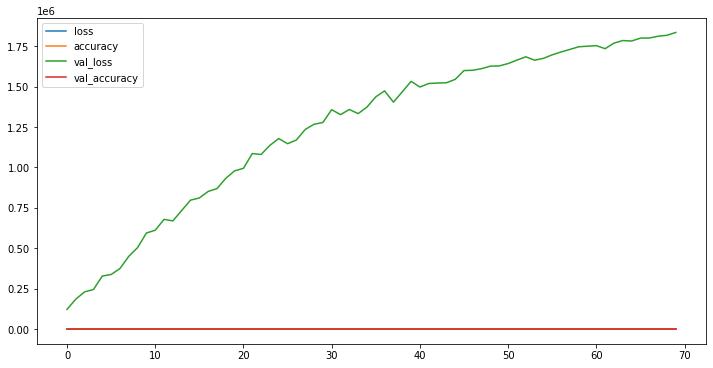

In [ ]:
import keras
model_2 = keras.models.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
])
print(model_2.summary())
model_1_history = trainModel(model=model_2, epochs=70, optimizer='adam')

plotHistory(model_1_history)

### Evaluate

In [ ]:
# def evaluate_model(train_x, train_y, val_x, val_y):

evaluate_model(
    model=model_2,
    train_x=X_train, 
    train_y=y_train, 
    val_x=X_test, 
    val_y=y_test
)

Train loss: 0.004
Train accuracy: 1.0
Validation loss: 1.5057
Validation accuracy: 0.6569


## Results

### Machine learning



#### 30 sec features

- Accuracy Naive Bayes: 0.49 
- Accuracy Stochastic Gradient Descent: 0.62333 
- Accuracy KNN: 0.58 
- Accuracy Decission trees: 0.57 
- Accuracy Random Forest: 0.73667 
- Accuracy Support Vector Machine: 0.64333 
- Accuracy Logistic Regression: 0.62 
- Accuracy Neural Nets: 0.64333 
- Accuracy Cross Gradient Booster: 0.78333 
- Accuracy Cross Gradient Booster (Random Forest): 0.57667 

<img src='https://drive.google.com/uc?id=17CM-h7YxH4KVSIjKIdm6daEECoZZNiyB'>

```
0.1520 ± 0.0331	length
0.0747 ± 0.0100	chroma_stft_mean
0.0733 ± 0.0140	perceptr_var
0.0413 ± 0.0137	rms_var
0.0347 ± 0.0155	mfcc5_var
0.0333 ± 0.0073	mfcc4_mean
0.0327 ± 0.0129	chroma_stft_var
0.0313 ± 0.0137	perceptr_mean
0.0313 ± 0.0209	harmony_mean
0.0260 ± 0.0186	mfcc13_var
0.0233 ± 0.0119	mfcc9_mean
0.0233 ± 0.0060	mfcc17_mean
0.0227 ± 0.0142	mfcc7_mean
0.0213 ± 0.0131	mfcc14_mean
0.0207 ± 0.0065	mfcc13_mean
0.0200 ± 0.0112	tempo
0.0200 ± 0.0219	zero_crossing_rate_mean
0.0180 ± 0.0053	mfcc7_var
0.0180 ± 0.0033	mfcc6_var
0.0167 ± 0.0112	mfcc19_var
```

#### 3 sec features

- Accuracy Naive Bayes: 0.51952 
- Accuracy Stochastic Gradient Descent: 0.65532 
- Accuracy KNN: 0.80581 
- Accuracy Decission trees: 0.64097 
- Accuracy Random Forest: 0.81415 
- Accuracy Support Vector Machine: 0.75409 
- Accuracy Logistic Regression: 0.6957 
- Accuracy Neural Nets: 0.84284 
- Accuracy Cross Gradient Booster: 0.87988 
- Accuracy Cross Gradient Booster (Random Forest): 0.58859 

<img src='https://drive.google.com/uc?id=137CFJPfUeESQ8GC4wME4OWFFEfOMbTmu'>

```
0.0902 ± 0.0090	perceptr_var
0.0493 ± 0.0067	perceptr_mean
0.0486 ± 0.0058	harmony_mean
0.0388 ± 0.0051	mfcc4_mean
0.0334 ± 0.0036	chroma_stft_mean
0.0266 ± 0.0038	harmony_var
0.0263 ± 0.0048	rms_var
0.0226 ± 0.0048	mfcc9_mean
0.0204 ± 0.0030	tempo
0.0187 ± 0.0037	mfcc11_mean
0.0167 ± 0.0036	mfcc3_mean
0.0153 ± 0.0026	mfcc6_mean
0.0140 ± 0.0037	mfcc3_var
0.0133 ± 0.0029	spectral_bandwidth_mean
0.0129 ± 0.0023	chroma_stft_var
0.0115 ± 0.0033	mfcc1_var
0.0113 ± 0.0036	mfcc7_mean
0.0093 ± 0.0030	mfcc5_mean
0.0091 ± 0.0042	mfcc13_mean
0.0089 ± 0.0055	mfcc1_mean
```